In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
train = tf.keras.utils.image_dataset_from_directory(
    "training-data",                             
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(180, 180),
    batch_size=32
)

validation = tf.keras.utils.image_dataset_from_directory(
    "training-data",                             
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(180, 180),
    batch_size=32
)

Found 1254 files belonging to 6 classes.
Using 1004 files for training.
Found 1254 files belonging to 6 classes.
Using 250 files for validation.


In [3]:
class_names = train.class_names

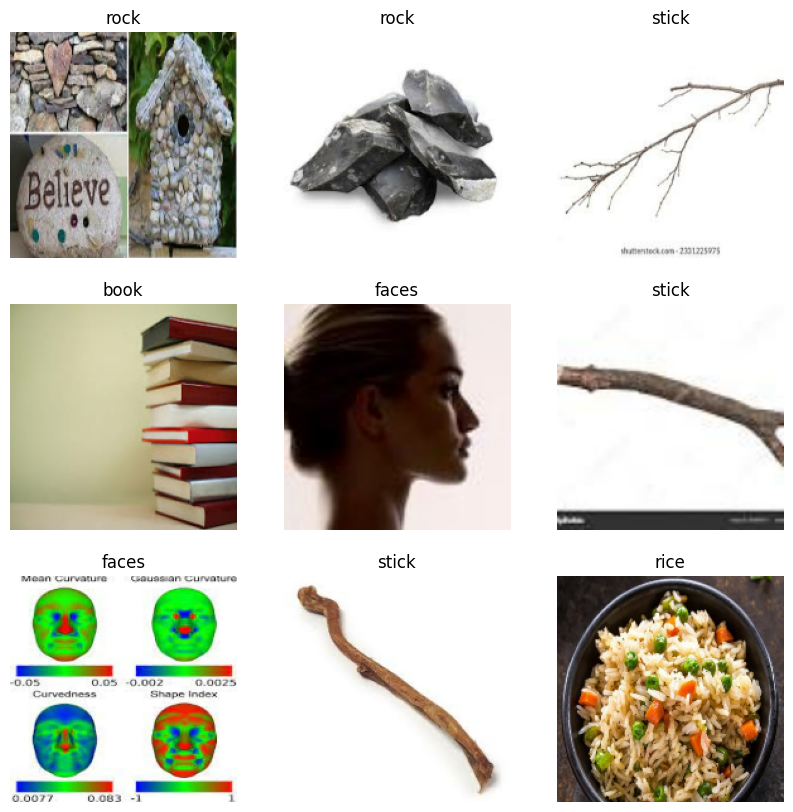

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
normalization_layer = layers.Rescaling(1./255)

normalized = train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2023-10-27 04:55:23.439297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-27 04:55:23.688004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


0.0 1.0


In [9]:
num_classes = len(class_names)
img_height = img_width = 180

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
epochs=10
history = model.fit(
  train,
  validation_data=validation,
  epochs=epochs
)

Epoch 1/10
32/32 [==============================] - 5s 154ms/step - loss: 1.8992 - accuracy: 0.2629 - val_loss: 1.6753 - val_accuracy: 0.2720
Epoch 2/10
32/32 [==============================] - 4s 137ms/step - loss: 1.5434 - accuracy: 0.4004 - val_loss: 1.4564 - val_accuracy: 0.4680
Epoch 3/10
32/32 [==============================] - 5s 161ms/step - loss: 1.2978 - accuracy: 0.5060 - val_loss: 1.3760 - val_accuracy: 0.4680
Epoch 4/10
32/32 [==============================] - 4s 141ms/step - loss: 1.0589 - accuracy: 0.6135 - val_loss: 1.2555 - val_accuracy: 0.5440
Epoch 5/10
32/32 [==============================] - 5s 149ms/step - loss: 0.8475 - accuracy: 0.6932 - val_loss: 1.2128 - val_accuracy: 0.5600
Epoch 6/10
32/32 [==============================] - 4s 139ms/step - loss: 0.6010 - accuracy: 0.8018 - val_loss: 1.2352 - val_accuracy: 0.6000
Epoch 7/10
32/32 [==============================] - 4s 138ms/step - loss: 0.4074 - accuracy: 0.8596 - val_loss: 1.2351 - val_accuracy: 0.6560
Epoch 

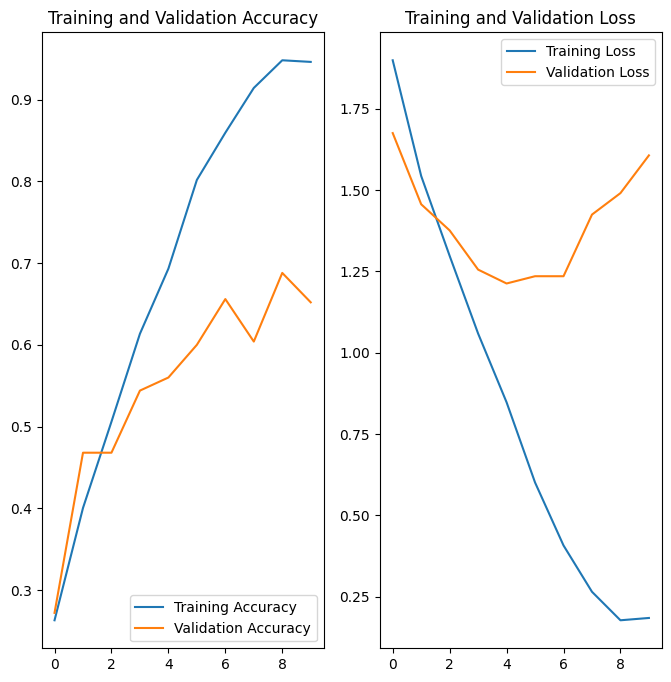

In [12]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [81]:
img = tf.keras.utils.load_img("Screenshot 2023-10-26 at 9.25.15 PM.png", target_size=(180, 180))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 48ms/step
This image most likely belongs to faces with a 72.45 percent confidence.


In [13]:
model.save('model.keras')

In [14]:
import tensorflowjs as tfjs

In [16]:
tfjs.converters.save_keras_model(model, "../src/model")